# Logistic Regression From Scratch

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_, score
from sklearn.preprocessing import PolynomialFeatures

In [49]:
class MultiClassLogReg():
    """Logistic Regression implementation with l2 regularization which can handle multi class classification problem"""
    def __init__(self,alpha=0.01,epochs=20000, C=1e10):
        self.alpha = alpha
        self.epochs = epochs
        self.C = C

    def add_bias(self,X):
        X0 = np.ones((X.shape[0],1))
        X = np.concatenate((X0,X),axis=1)
        return X

    def init_weights(self):
        self.W = np.zeros((self.X.shape[1]))

    def sigmoid(self,X):
        H = 1/(1+np.exp(-X))
        return H

    def calculate_cost(self):
        self.cost = -(self.Y.T@np.log(self.H)+(1-self.Y).T@np.log(1-self.H))/self.Y.shape[0]
        return self.cost
    
    def fit_one_vs_all(self,X,Y):
        self.X = X
        self.Y = Y
        self.X = self.add_bias(self.X)
        self.init_weights()
        for i in range(0,self.epochs):
            self.Z = self.X@(self.W).T
            self.H = self.sigmoid(self.Z)
            grad = (self.Y-self.H).T@ self.X
            self.W = self.W+(self.alpha)*(grad-2*self.W/self.C)
            if i%10000==0:
                pass
        return self.W

    def fit(self,X,Y):
        count = 0
        for GT in np.unique(Y):
            count+=1
            Yclass = (y_train==GT).astype(int)
            w = self.fit_one_vs_all(X,Yclass)
            print(w)
            if count ==1:
                self.W_all = w
            else:
                self.W_all = np.vstack((self.W_all,w))
        return self.W_all


    def predict_proba_one_vs_all(self,Xpred,W=None):
        if W is not None:
            self.W = W
        Xpred = self.add_bias(Xpred)
        H = Xpred@(self.W).T
        pred = self.sigmoid(H)
        return pred#, 1-pred

    def predict_proba(self,X):
        for i in range(self.W_all.shape[0]):
            pred_one = self.predict_proba_one_vs_all(X,self.W_all[:][i])
            if i==0:
                pred_all = pred_one
            else:
                pred_all = np.vstack((pred_all,pred_one))
        return pred_all

    def predict(self,Xpred,W=None):
        predictions = self.predict_proba(Xpred)
        return np.argmax(predictions,axis =0)




In [12]:
class LogReg():

    def __init__(self,X,Y,alpha,epochs, C=1e10):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.epochs = epochs
        self.C = C

    def add_bias(self,X):
        X0 = np.ones((X.shape[0],1))
        X = np.concatenate((X0,X),axis=1)
        # print(f"Bias added {X.shape}")
        return X

    def init_weights(self):
        self.W = np.zeros((self.X.shape[1]))
        #return self.W

    def sigmoid(self,X):
        #Z = X@(self.W).T
        H = 1/(1+np.exp(-X))
        return H

    def calculate_cost(self):
        self.cost = -(self.Y.T@np.log(self.H)+(1-self.Y).T@np.log(1-self.H))/self.Y.shape[0]
        return self.cost
    
    def fit(self):
        self.X = self.add_bias(self.X)
        self.init_weights()
        #print(self.X.shape)
        for i in range(0,self.epochs):
            self.Z = self.X@(self.W).T
            self.H = self.sigmoid(self.Z)
            # grad = (self.H-self.Y).T@ self.X
            grad = (self.Y-self.H).T@ self.X
            self.W = self.W+(self.alpha)*(grad-2*self.W/self.C)
            if i%10000==0:
                pass
                #print(self.calculate_cost())
        return self.W
    
    def predict_proba(self,Xpred):
        Xpred = self.add_bias(Xpred)
        H = Xpred@(self.W).T
        pred = self.sigmoid(H)
        return pred#, 1-pred
    
    def predict(self,Xpred):
        pred = self.predict_proba(Xpred)
        return np.where(pred>0.5,1,0)

### NOTE
* np.dot seems to do matrix multiplication for N dimensiona array and dot product for 1D array. 
* Dimensions of weights should be similar to Y. i.e. if Y is (100,) weights should be (X.shape(1)) not  (X.shape(1),1). Cost function became (100,100) as Y was (100,) and H was (100,1) 
* Nan Cost: log component causes it?

## Iris Dataset
Lets make a classification with only one feature. We select petal width as it has a linear seperable decision boundary for class 0 and 1 as seen in the scatter plot below.


Note:
Sklearn has regularization by default. High C means lesser regularization

In [13]:
# iris = pd.read_csv('./data/iris.csv')
# #iris = iris[~(iris['species']=='setosa')].reset_index(drop= True)
# Y = (iris["species"] == 'versicolor').astype(np.int) 
# X = np.array(iris['petal_width']).reshape(-1,1)

In [14]:
# Iris Dataset 
from sklearn import datasets
iris = datasets.load_iris()
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"][:, 3:] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
df_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

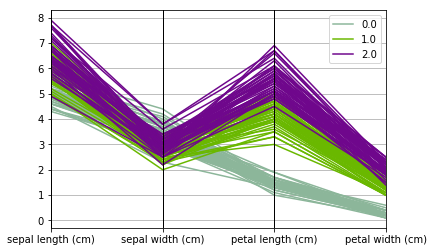

In [15]:
from pandas.tools.plotting import parallel_coordinates
parallel_coordinates(df_iris, "target")

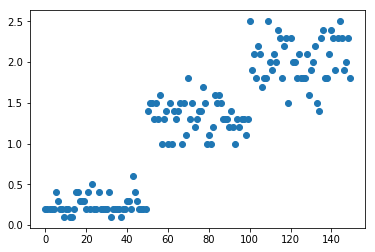

In [16]:
plt.scatter(np.arange(0,150), X)

In [17]:
def get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test, visualize =False):
    lr_100 = LogReg(X_train,y_train,0.01,100)
    w_100 = lr_100.fit()
    prediction_100 = lr_100.predict(X_test)

    lr_10000 = LogReg(X_train,y_train,0.01,10000)
    w_10000 = lr_10000.fit()
    prediction_10000 = lr_10000.predict(X_test)

    sk_lr = LogisticRegression(fit_intercept = True)
    sk_lr.fit(X_train,y_train)
    sk_Pred = sk_lr.predict(X_test)

    sk_lr_no_C = LogisticRegression(fit_intercept = True, C = 1e15)
    sk_lr_no_C.fit(X_train,y_train)
    sk_Pred_no_C = sk_lr_no_C.predict(X_test)

    print("-------------------")
    print('Intercepts for my implementation 100 iterations')
    print(w_100)
    print('Intercepts for my implementation 10000 iterations')
    print(w_10000)
    print('Intercepts for sklearn')
    print(sk_lr.intercept_, sk_lr.coef_)
    print('Intercepts for sklearn no regularization')
    print(sk_lr_no_C.intercept_, sk_lr_no_C.coef_)
    print("-------------------")
    print('Confusion metrics for sklearn')
    print(metrics.confusion_matrix(sk_Pred,y_test))
    print('Confusion metrics for my implementation 10000 iterations')
    print(confusion_matrix(prediction_10000, y_test))
    print("-------------------")

    if visualize is True:
        X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
        y_proba_10000 = lr_10000.predict_proba(X_new)
        y_proba_sk = sk_lr.predict_proba(X_new)
        y_proba_sk_no_C = sk_lr_no_C.predict_proba(X_new)
        plt.plot(X_new, y_proba_10000, "g-")
        plt.plot(X_new, y_proba_sk[:,1], "b--")
        plt.plot(X_new, y_proba_sk_no_C[:,1], "r--")
        plt.plot(X[Y==0], Y[Y==0], "bs")
        plt.plot(X[Y==1], Y[Y==1], "g^")
        plt.legend(['From Scratch 10000 epochs', 'Sklearn', 'Sklearn no reg'])

In [18]:
# # test
# X = iris["data"][:, (2, 3)]  # petal length, petal width
# y = (iris["target"] == 1).astype(np.int)
# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=1)
# get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test, visualize=True)

-------------------
Intercepts for my implementation 100 iterations
[ 3.52039961 -5.04593791]
Intercepts for my implementation 10000 iterations
[ 12.3230329  -16.62172055]
Intercepts for sklearn
[2.49477843] [[-3.71098155]]
Intercepts for sklearn no regularization
[26.90321528] [[-34.81734384]]
-------------------
Confusion metrics for sklearn
[[20  0]
 [ 0 10]]
Confusion metrics for my implementation 10000 iterations
[[20  0]
 [ 0 10]]
-------------------


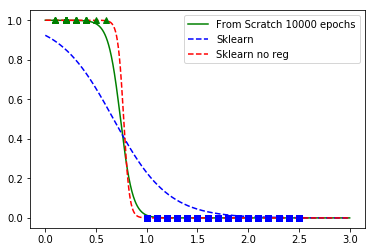

In [19]:
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test, visualize=True)

### Interpretation
Even though the weights are differents, the confusion matrix looks same. To dig deeper lets plot the decision boundary.
Since our loss function is convex there should be a global maxima (my implementation almost matches sklearn with no regularization by 10000 epochs), there are other factors coming into play here. Lets discuss them.

Higher epoch fits well, hence has a steeper decision boundary. For a threshold of 0.5 all implementations might be giving same results. But if I tweak the thresholds they will have different results. 
When the data points are linearly seperable there can be infinite hyperparameters/decision boundary/planes which demarcates the classes. How to select the best one?
Is a steep decision boundary desirable?
 With MLE, we are trying to maximize our probabilty. So it will try to demarcate the classes as best as possible. So even for the data points very close to the boundary, probability ~0,1. But we would want the model to give us a low confidence score near the boundaries. This will ensure we dont overfit.

For steeper sigmoid, even a very small change in x will can flip our decision which might not be preferable.

### Overfitting in LogReg:
* Over Complex Decision Boundaries:
Below i have plotted the same analysis for class 3 which isnt linearly seperable. We again get a steep curve which doesnt give any ambiguity where there is an overlap of classes. Extending our example to higher orders, the boundaries can get overly complex very easily with MLE. 

* Coefficients go infinite:
If we check the coefficient values in above case, as epoch increase my weights are increasing. Thus, there is a direct correlation between the magnitude of weight and the level of overfitting.   

-------------------
Intercepts for my implementation 100 iterations
[-5.2864748   3.36969713]
Intercepts for my implementation 10000 iterations
[-19.80709489  12.39608287]
Intercepts for sklearn
[-3.78370879] [[2.45245977]]
Intercepts for sklearn no regularization
[-20.11360481] [[12.58963421]]
-------------------
Confusion metrics for sklearn
[[22  0]
 [ 2  6]]
Confusion metrics for my implementation 10000 iterations
[[22  0]
 [ 2  6]]
-------------------


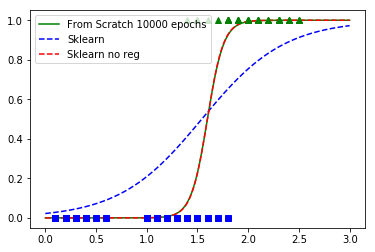

In [20]:
Y = (iris["target"] == 2).astype(np.int) 
X = iris["data"][:, 3:] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=1)
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test,visualize=True)


## Need of Normalization

For the following data, if I use the features as is, my cost function was going to Nan and my GD wasnt converging. But as soon as i normalize the data, it converges beautifully and much faster then earlier. Why so? The features are marks and hence have same min,max. 
Lets check the weight update after first iteration. Since the loss is very high, weights get updated too much at the start itself. Also, normalization ensures smoother trajectory of gradient descent. Need of normalization is very specific to the method we use for maximization. There might be some other optimization technique which may work even without normalization. 
Even though normalization converges GD faster, the problem of overfitting remains. Check the weight magnitude.
Note: Check standardization vs normalization in Gyan section for more details.

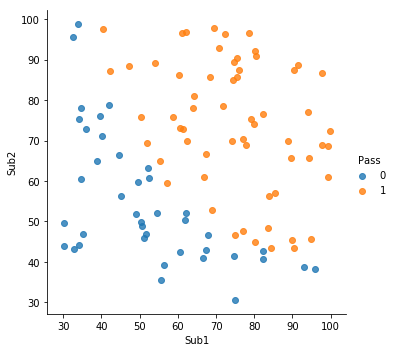

In [21]:
df = pd.read_csv("./data/ex2data1.txt", names=['Sub1','Sub2','Pass'])#header=None)
sns.lmplot(x='Sub1',y='Sub2',data=df,fit_reg=False,hue='Pass')
Y= df['Pass']
X = df.drop('Pass', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=1)
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test)


-------------------
Intercepts for my implementation 100 iterations
[-6.21503576  4.08791634  1.9624324 ]
Intercepts for my implementation 10000 iterations
[-596.19144391   26.04115366   23.81773632]
Intercepts for sklearn
[-3.39913181] [[0.03415093 0.02877412]]
Intercepts for sklearn no regularization
[-26.71421968] [[0.22010981 0.21651989]]
-------------------
Confusion metrics for sklearn
[[ 4  0]
 [ 5 11]]
Confusion metrics for my implementation 10000 iterations
[[ 0  0]
 [ 9 11]]
-------------------


### Z score Standardization
$$ X_{std} = \frac{X-X_{\mu}}{\sigma} $$

In [23]:
# Try standardization(Z score)
Xstd = (X-X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(Xstd,Y,test_size=0.2, random_state=1)
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test)

-------------------
Intercepts for my implementation 100 iterations
[1.36102811 2.96973355 2.76093161]
Intercepts for my implementation 10000 iterations
[2.2848564  4.74244672 4.469926  ]
Intercepts for sklearn
[0.9426686] [[2.12905608 1.97828053]]
Intercepts for sklearn no regularization
[2.28484085] [[4.7424164 4.4698953]]
-------------------
Confusion metrics for sklearn
[[ 7  1]
 [ 2 10]]
Confusion metrics for my implementation 10000 iterations
[[ 7  1]
 [ 2 10]]
-------------------


### Min-Max Normalization
$$ X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}} $$

In [24]:
# Try normalization min-max
Xnorm = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(Xnorm,Y,test_size=0.2, random_state=1)
get_weights_and_confusion_matrix(X_train, X_test, y_train, y_test)

-------------------
Intercepts for my implementation 100 iterations
[-2.18017479  2.88679568  2.66737808]
Intercepts for my implementation 10000 iterations
[-13.98370907  15.92203488  15.34302039]
Intercepts for sklearn
[-1.69426893] [[2.33970201 2.18358906]]
Intercepts for sklearn no regularization
[-14.95586704] [[17.00431709 16.42071582]]
-------------------
Confusion metrics for sklearn
[[ 5  0]
 [ 4 11]]
Confusion metrics for my implementation 10000 iterations
[[ 7  1]
 [ 2 10]]
-------------------


Both standardization and normalization seem to be giving similar results. 
Note: Always remember to scale the test data with the mean/sigma obtained while scaling training data to get correct results.

## Gradient Descent

Our cost function is log likelihood defined as:
$$ L(H|y) = -y.log(H)-(1-y)log(1-H) $$
Simplifying it further:
$$ L(H|y) = -y.log(\frac{1}{1+e^{-W^{T}x}})-(1-y)log(\frac{e^{-W^{T}x}}{1+e^{-W^{T}x}}) $$
$$ L(H|y) = y.log(1+e^{-W^{T}x})-(1-y)log(e^{-W^{T}x})+(1-y)log(1+e^{-W^{T}x}) $$
$$ L(H|y) = (1-y)W^{T}x+log(1+e^{-W^{T}x}) $$
Minimizing cost means maximizing the probability/ likelihood. Using chain rule:
$$\frac{\delta L}{\delta\omega} = \frac{\delta L}{\delta H}.\frac{\delta H}{\delta Z} .\frac{\delta Z}{\delta \omega} $$
$$\frac{\delta L}{\delta H} = -\frac{y}{H}+\frac{1-y}{1-H} $$
$$\frac{\delta Z}{\delta \omega} = \frac{e^{-Z}}{(1+e^{-Z})^{2}}$$
$$ \frac{\delta L}{\delta\omega_{i}} = X^{T}.Y$$
$$  = H.(1-H)$$
Thus,
$$ \frac{\delta L}{\delta\omega} = X^{T}.(H-Y)$$
                  
##### TODO Convert everything to matrix form, gradient ascent
log likelihoood and loss different?

$$ \omega = \omega - \alpha.\frac{\delta L}{\delta\omega} $$
         

### Iris with 2 features

In [25]:

def fit_and_draw_contour(X,y,degree=1, C= 1e20, implementation = 'sk'):
    poly = PolynomialFeatures(degree=degree,include_bias=False)

    X = poly.fit_transform(X)
    x0, x1 = np.meshgrid(
            np.linspace(0, 7, 500).reshape(-1, 1),
            np.linspace(0, 2.7, 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = poly.fit_transform(X_new)

    if implementation == 'scratch':
        log_reg = LogReg(X, y,0.01,20000,C=C)
        w_100 = log_reg.fit()
        #print(w_100)
        y_proba = log_reg.predict_proba(X_new)
        zz = y_proba.reshape(x0.shape)

    if implementation == 'sk':
        log_reg = LogisticRegression(solver="lbfgs",C=C, max_iter=10000, random_state=42)
        log_reg.fit(X, y)

        y_proba = log_reg.predict_proba(X_new)
        zz = y_proba[:, 1].reshape(x0.shape)

    plt.figure(figsize=(10, 4))
    plt.plot(X[y==0, 0], X[y==0, 1], "bs")
    plt.plot(X[y==1, 0], X[y==1, 1], "g^")


    contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


    # left_right = np.array([2.9, 7])
    # boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

    plt.clabel(contour, inline=1, fontsize=12)
    # plt.plot(left_right, boundary, "k--", linewidth=3)
    # plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
    # plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.axis([0, 7, 0, 2.7])
    #save_fig("logistic_regression_contour_plot")
    plt.show()

Lets check the fit for class 3. The decision boundary is a line (so decision boundary is where $ypred = 0.5$. So that means Wx+b =0 which is a line. If we make x a polynomial it wont be a line, shown later)

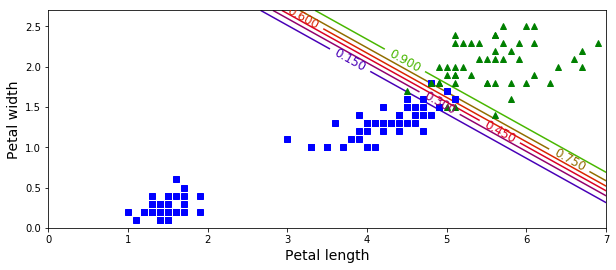

In [26]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

fit_and_draw_contour(X,y,degree = 1)

Lets check for class 2. Since it is in between the otehr two classes, it is impossible for a logistic regression with linear features to fit it. 
Lets try adding polynomial features (eg. $x_{i}^{2}$, $x_{i}*x_{j}$)

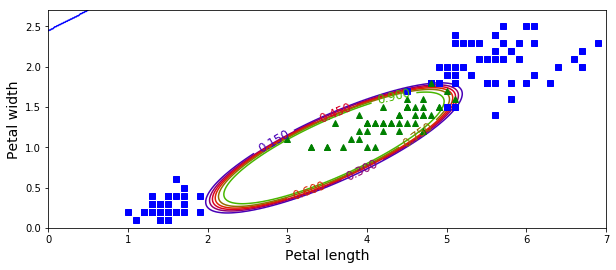

In [27]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 1).astype(np.int)
fit_and_draw_contour(X,y,degree = 2)   

To see the effect of overfitting in polynomial regression lets increase the degree of polynomial. We expect the decision boundary to get over complex.

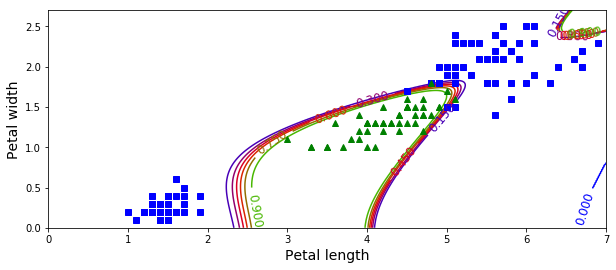

In [28]:
fit_and_draw_contour(X,y,degree = 5)

Lets see if adding regularization can help mitigate overfitting. For the same case of degree 5 we add regularization. Note: If i tried with degree 10, the regularization didnt seem to help much.

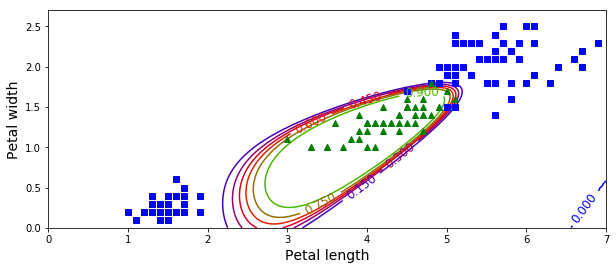

In [29]:
fit_and_draw_contour(X,y,degree = 5, C=1)

Regularization has lamost made the contour back to an ellipse.

Just to check how it looks with normalization. The data is squished to [0,1] while i plot for the earlier scale. But this gives a feel for how overfitting maps contour where we dont even have any data points

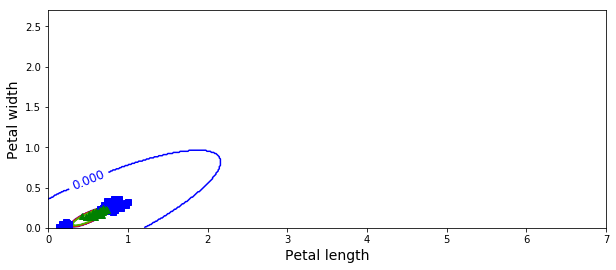

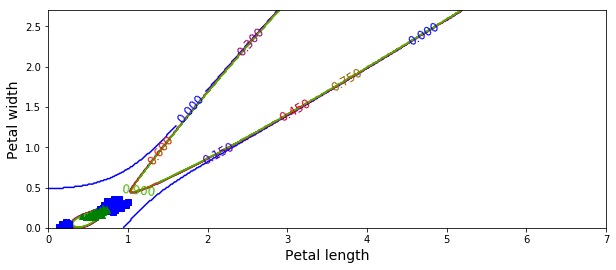

In [30]:
Xnorm = (X-X.min())/(X.max()-X.min())
fit_and_draw_contour(Xnorm,y,degree = 2)
fit_and_draw_contour(Xnorm,y,degree = 5)

### L2 Regularization
To avoid overfiiting we need to add representation of magnitude of weight in our cost function in addition to the error. In L2 (Ridge) regularization we take L2 norm as given below:
$$ cost = \cal{L}(y,y^{\^}) + \frac{\lambda }{2}||W||^2_2 $$

If \lambda
Thus the GD update becomes:
$$ w = w + \alpha(\frac{\delta \cal{L}}{\delta \omega} -\lambda\omega)$$

For the sake of completeness let's code if my implementation of multinomial logistic regression is reproducing the same results 
TODO: It isnt. Problem of local minima? How to find tht? Try lbfs optimization?

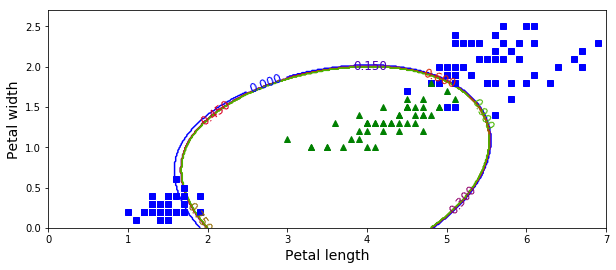

In [31]:
fit_and_draw_contour(X,y,degree = 4,  implementation = 'scratch') #C=1,

### Tuning lambda 

## One vs All
Logistic regression can handle only two classes. To classify multi class data, we split the task into individual binary classification problem taking one class at a time. 

In [86]:
Y = iris["target"] 
X = iris["data"] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

sk_lr = LogisticRegression(penalty = 'l1', fit_intercept = True, C=1)
sk_lr.fit(X_train,y_train)
sk_Pred = sk_lr.predict(X_test)
print(metrics.confusion_matrix(sk_Pred,y_test))

lr = MultiClassLogReg() 
w = lr.fit(X_train, y_train)
Ypred = lr.predict(X_test)
print(metrics.confusion_matrix(Ypred,y_test))

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
[ 0.78371213  1.25438513  4.31258968 -6.83647918 -3.25173518]
[ 47.77925849  -0.89603474 -20.562635     8.14408692 -23.65580957]
[-19.30888656  -2.46026054  -6.29605811   6.50923795  12.29250164]
[[10  1  0]
 [ 0  3  0]
 [ 0  5 11]]


In [87]:
# Try with different and stricter regularization
print(metrics.confusion_matrix(sk_Pred,y_test))

lr = MultiClassLogReg(C=100) 
w = lr.fit(X_train, y_train)
Ypred = lr.predict(X_test)
print(metrics.confusion_matrix(Ypred,y_test))

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
[ 0.47622989  0.78884887  2.79436046 -4.31599713 -2.07731893]
[ 24.37260605   6.46336622 -18.97750347   7.03360989 -21.4514017 ]
[-8.28989258 -4.01322101 -6.5149213   7.20400881  9.82326661]
[[10  0  0]
 [ 0  9  4]
 [ 0  0  7]]


For all trials of regularizations, my one vs all implementation was failing. But once i added standardization it fit beautifully. This might be specific to gradient descent being used for optimization. But we see that standardization and regularization have different roles to play and both ave their own importance. Regularization prevents overfitting while standardization helps smoother convergence of GD. 

In [93]:
Y = iris["target"] 
X = iris["data"] # petal width
Xstd = (X-X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(Xstd,Y,test_size=0.2, random_state=42)

sk_lr = LogisticRegression(fit_intercept = True)
sk_lr.fit(X_train,y_train)
sk_Pred = sk_lr.predict(X_test)
print(metrics.confusion_matrix(sk_Pred,y_test))

lr = MultiClassLogReg() 
w = lr.fit(X_train, y_train)
Ypred = lr.predict(X_test)
print(metrics.confusion_matrix(Ypred,y_test))

[[10  0  0]
 [ 0  8  0]
 [ 0  1 11]]
[ -2.9195518   -4.20677564   6.77456774 -11.79226442  -1.9781279 ]
[-7.91101695  0.09381766 -5.73852491  2.00637786 -4.68428867]
[10.9206888  -4.42825749 -9.49857769 15.00853356 20.68847648]
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


In [ ]:
# # test multiclass class

# #implement one vs all
# # 
# Y = iris["target"] 
# X = iris["data"] # petal width
# Xstd = (X-X.mean())/X.std()
# # Xstd = X
# X_train, X_test, y_train, y_test = train_test_split(Xstd,Y,test_size=0.2, random_state=42)

# WeightsAllClasses = []
# lr = MultiClassLogReg() #C=1
# lr_sk = LogisticRegression()
# for GT in np.unique(Y):
#     print(GT)
#     Yclass = (y_train==GT).astype(int)
#     # print(Yclass)
#     w = lr.fit(X_train, Yclass)
#     lr_sk.fit(X_train,Yclass)
#     # print(sum(lr.predict_proba(X,w)))
#     # print(sum(lr_sk.predict_proba(X)))
#     print(w)
#     print(lr_sk.intercept_, lr_sk.coef_)
#     # print()
#     WeightsAllClasses.append(w)

# YpredAllClasses = []
# for i in range(len(WeightsAllClasses)):
#     ypred = lr.predict_proba(X_test,WeightsAllClasses[i]) 
#     print(ypred[50:100])
#     YpredAllClasses.append(ypred)
# Ypred = np.argmax(np.array(YpredAllClasses),axis =0)
# print(metrics.confusion_matrix(Ypred,y_test))

In [ ]:
#test new mlr class
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"][:, 3:] # petal width
lr = MultiClassLogReg()
w = lr.fit(X, Y)
lr_sk = LogisticRegression()
lr_sk.fit(X,Y)
print(sum(lr.predict_proba(X[1:100],w)))
print(sum(lr_sk.predict_proba(X[1:100])))

In [77]:
# #implement one vs all
# # 
# Y = iris["target"] 
# X = iris["data"] # petal width
# # Xstd = (X-X.mean())/X.std()
# Xstd = X
# X_train, X_test, y_train, y_test = train_test_split(Xstd,Y,test_size=0.2, random_state=42)

# WeightsAllClasses = []
# lr_sk = LogisticRegression()
# for GT in np.unique(Y):
#     print(GT)
#     Yclass = (y_train==GT).astype(int)
#     # print(Yclass)
#     lr = LogReg(X_train, Yclass,0.01,10000)
#     w = lr.fit()
#     lr_sk.fit(X_train,Yclass)
#     # print(sum(lr.predict_proba(X,w)))
#     # print(sum(lr_sk.predict_proba(X)))
#     print(w)
#     print(lr_sk.intercept_, lr_sk.coef_)
#     # print()
#     WeightsAllClasses.append(w)

# YpredAllClasses = []
# for i in range(len(WeightsAllClasses)):
#     ypred = lr.predict_proba(X_test,WeightsAllClasses[i]) 
#     print(ypred[50:100])
#     YpredAllClasses.append(ypred)
# Ypred = np.argmax(np.array(YpredAllClasses),axis =0)
# print(metrics.confusion_matrix(Ypred,y_test))

## Feature Selection
* Observe weights
* l1 regularization
* PCA or LDA: They remove dimensionality by selecting a certain combination of features. Hence they wont give interpretability as to which feature got selected if thats a requirement.
* Forward and backward selection:

In [82]:
# Observing Weights
 
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"] 

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
sk_lr = LogisticRegression( fit_intercept = True, C=1)
sk_lr.fit(X_train,y_train)
sk_Pred = sk_lr.predict(X_test)
print(metrics.confusion_matrix(sk_Pred,y_test))
print(sk_lr.intercept_, sk_lr.coef_)

[[20  0]
 [ 0 10]]
[0.2478905] [[ 0.3711229   1.409712   -2.15210117 -0.95474179]]


In [83]:
# Observing Weights after normalization of features
 
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"] 
Xstd = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(Xstd,Y,test_size=0.2, random_state=42)
sk_lr = LogisticRegression( fit_intercept = True, C=1)
sk_lr.fit(X_train,y_train)
sk_Pred = sk_lr.predict(X_test)
print(metrics.confusion_matrix(sk_Pred,y_test))
print(sk_lr.intercept_, sk_lr.coef_)

[[20  0]
 [ 0 10]]
[1.28234914] [[-0.72310148  1.5716721  -4.47309923 -1.89276137]]


We see the weights for third feature is the highest. But still how do we find the threshold above which we consider the weights significant. For the same reason we move to lasso regularization.

In [94]:
Y = (iris["target"] == 0).astype(np.int) 
X = iris["data"] # petal width
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

sk_lr = LogisticRegression(penalty = 'l1', fit_intercept = True, C=1)
sk_lr.fit(X_train,y_train)
sk_Pred = sk_lr.predict(X_test)
print(metrics.confusion_matrix(sk_Pred,y_test))
print(sk_lr.intercept_, sk_lr.coef_)

[[20  0]
 [ 0 10]]
[0.] [[ 0.          2.36559851 -2.67556951  0.        ]]


l1 regularization gives a clearer picture by reducing the irrelevant weights to zero.